[Download the Data]('https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data')

# House Prices: Advanced Regression Techniques

## Competition Description


Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

## Practice Skills
- Creative feature engineering 
- Advanced regression techniques like random forest and gradient boosting


In [42]:
#%%writefile imports.py
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go 
import os
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor
%matplotlib inline
import sklearn.metrics as metrics
from math import sqrt
for dirname, _, filenames in os.walk('../data/houseprice'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/houseprice/data_description.txt
../data/houseprice/sample_submission.csv
../data/houseprice/train.csv
../data/houseprice/test.csv


In [43]:
df = pd.read_csv('../data/houseprice/train.csv')

In [44]:
df_test = pd.read_csv('../data/houseprice/test.csv')

In [45]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# To start lets discover which columns have NaN values!

In [46]:
all_df = pd.concat([df_test.copy(),df.drop('SalePrice',axis=1).copy()])

In [47]:
nan_columns  = all_df.loc[:,all_df.isnull().any()].columns

In [48]:
#type of nan_columns
all_df.loc[:,nan_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1459
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSZoning      2915 non-null   object 
 1   LotFrontage   2433 non-null   float64
 2   Alley         198 non-null    object 
 3   Utilities     2917 non-null   object 
 4   Exterior1st   2918 non-null   object 
 5   Exterior2nd   2918 non-null   object 
 6   MasVnrType    2895 non-null   object 
 7   MasVnrArea    2896 non-null   float64
 8   BsmtQual      2838 non-null   object 
 9   BsmtCond      2837 non-null   object 
 10  BsmtExposure  2837 non-null   object 
 11  BsmtFinType1  2840 non-null   object 
 12  BsmtFinSF1    2918 non-null   float64
 13  BsmtFinType2  2839 non-null   object 
 14  BsmtFinSF2    2918 non-null   float64
 15  BsmtUnfSF     2918 non-null   float64
 16  TotalBsmtSF   2918 non-null   float64
 17  Electrical    2918 non-null   object 
 18  BsmtFullBath  2917 non-null 

# Okay, we already now the columns that can have missing values!

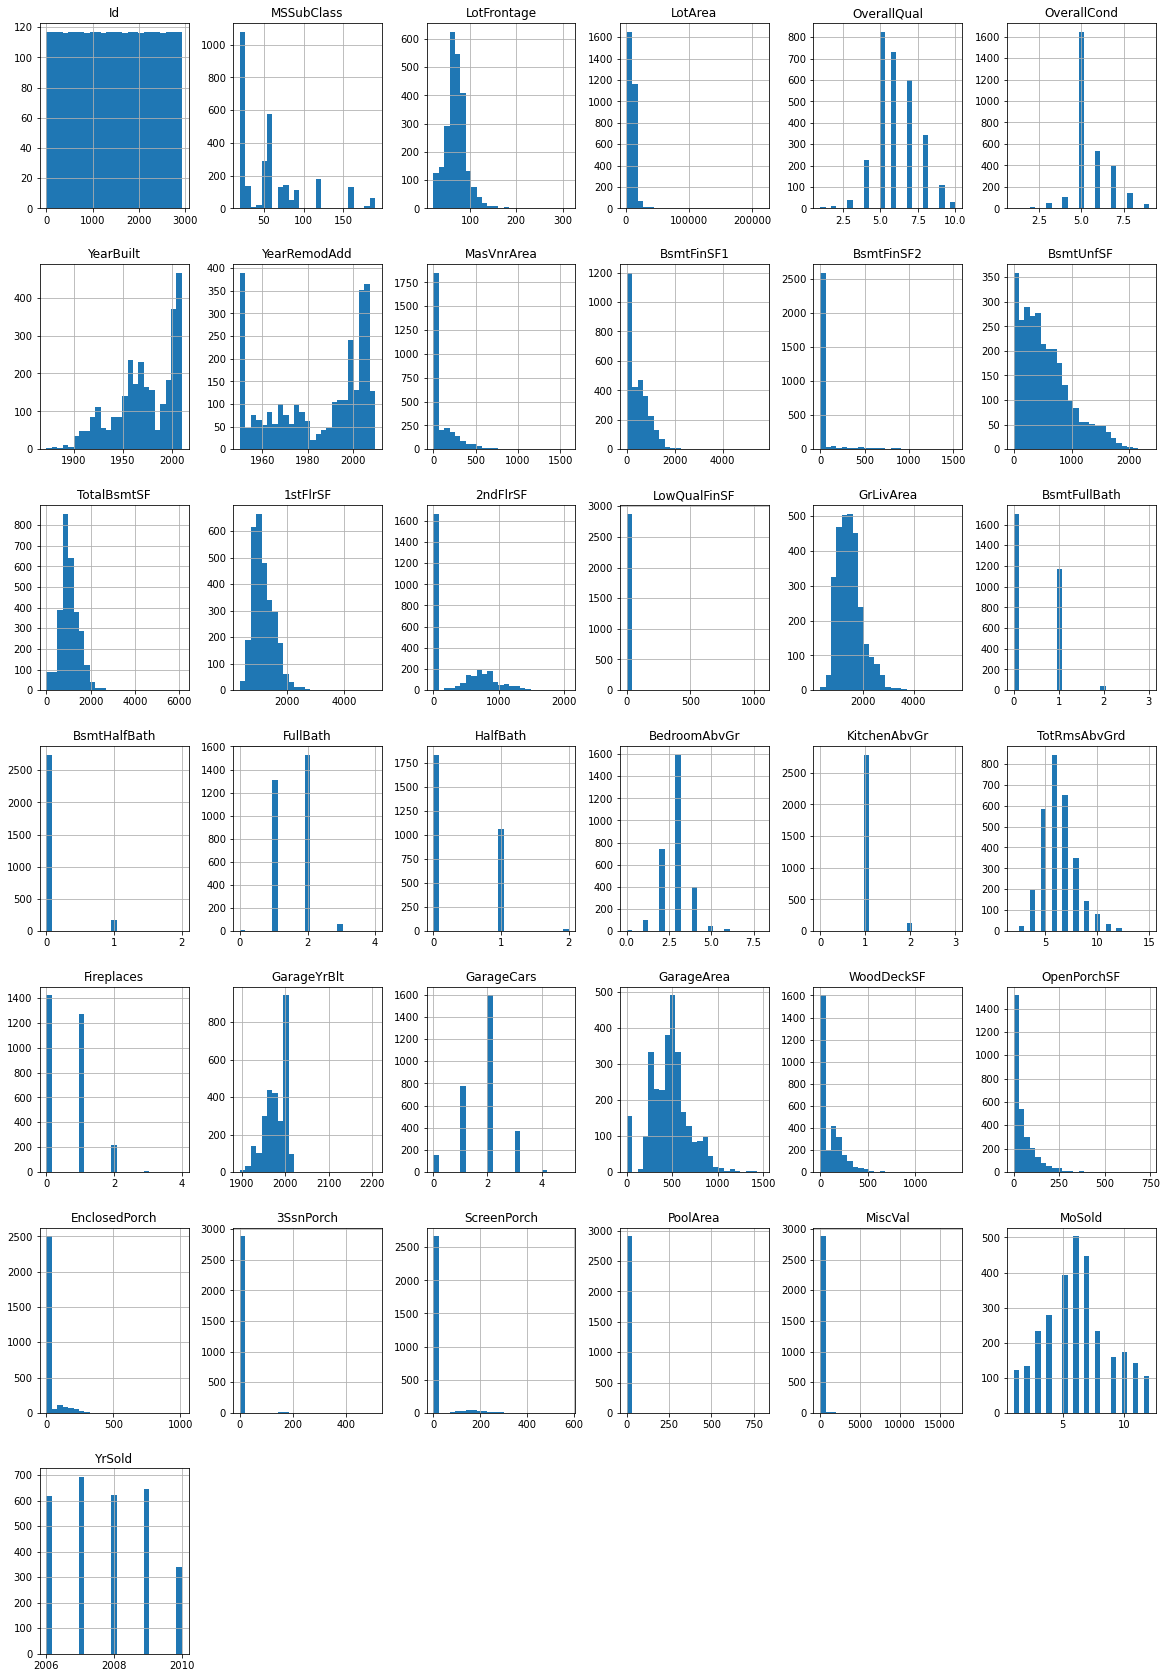

In [49]:
all_df.hist(bins=25);
plt.gcf().set_size_inches(20,30);

In [50]:
#Description of all columns!
description = {'MSSubClass':'The building class',
'MSZoning':'The general zoning classification',
'LotFrontage':'Linear feet of street connected to property',
'LotArea':'Lot size in square feet',
'Street':'Type of road access',
'Alley':'Type of alley access',
'LotShape':'General shape of property',
'LandContour':'Flatness of the property',
'Utilities':'Type of utilities available',
'LotConfig':'Lot configuration',
'LandSlope':'Slope of property',
'Neighborhood':'Physical locations within Ames city limits',
'Condition1':'Proximity to main road or railroad',
'Condition2':'Proximity to main road or railroad (if a second is present)',
'BldgType':'Type of dwelling',
'HouseStyle':'Style of dwelling',
'OverallQual':'Overall material and finish quality',
'OverallCond':'Overall condition rating',
'YearBuilt':'Original construction date',
'YearRemodAdd':'Remodel date',
'RoofStyle':'Type of roof',
'RoofMatl':'Roof material',
'Exterior1st':'Exterior covering on house',
'Exterior2nd':'Exterior covering on house (if more than one material)',
'MasVnrType':'Masonry veneer type',
'MasVnrArea':'Masonry veneer area in square feet',
'ExterQual':'Exterior material quality',
'ExterCond':'Present condition of the material on the exterior',
'Foundation':'Type of foundation',
'BsmtQual':'Height of the basement',
'BsmtCond':'General condition of the basement',
'BsmtExposure':'Walkout or garden level basement walls',
'BsmtFinType1':'Quality of basement finished area',
'BsmtFinSF1':'Type 1 finished square feet',
'BsmtFinType2':'Quality of second finished area (if present)',
'BsmtFinSF2':'Type 2 finished square feet',
'BsmtUnfSF':'Unfinished square feet of basement area',
'TotalBsmtSF':'Total square feet of basement area',
'Heating':'Type of heating',
'HeatingQC':'Heating quality and condition',
'CentralAir':'Central air conditioning',
'Electrical':'Electrical system',
'1stFlrSF':'First Floor square feet',
'2ndFlrSF':'Second floor square feet',
'LowQualFinSF':'Low quality finished square feet (all floors)',
'GrLivArea':'Above grade (ground) living area square feet',
'BsmtFullBath':'Basement full bathrooms',
'BsmtHalfBath':'Basement half bathrooms',
'FullBath':'Full bathrooms above grade',
'HalfBath':'Half baths above grade',
'Bedroom':'Number of bedrooms above basement level',
'Kitchen':'Number of kitchens',
'KitchenQual':'Kitchen quality',
'TotRmsAbvGrd':'Total rooms above grade (does not include bathrooms)',
'Functional':'Home functionality rating',
'Fireplaces':'Number of fireplaces',
'FireplaceQu':'Fireplace quality',
'GarageType':'Garage location',
'GarageYrBlt':'Year garage was built',
'GarageFinish':'Interior finish of the garage',
'GarageCars':'Size of garage in car capacity',
'GarageArea':'Size of garage in square feet',
'GarageQual':'Garage quality',
'GarageCond':'Garage condition',
'PavedDrive':'Paved driveway',
'WoodDeckSF':'Wood deck area in square feet',
'OpenPorchSF':'Open porch area in square feet',
'EnclosedPorch':'Enclosed porch area in square feet',
'3SsnPorch':'Three season porch area in square feet',
'ScreenPorch':'Screen porch area in square feet',
'PoolArea':'Pool area in square feet',
'PoolQC':'Pool quality',
'Fence':'Fence quality',
'MiscFeature':'Miscellaneous feature not covered in other categories',
'MiscVal':'$Value of miscellaneous feature',
'MoSold':'Month Sold',
'YrSold':'Year Sold',
'SaleType':'Type of sale',
'SaleCondition':'Condition of sale'}

In [51]:
#priting the columns with nan and their description
print('\nColumns with NaN: Description and type:\n')
for i in nan_columns:
    if i in description.keys():
        print(i+':'+description[i]+' - type: {}, N: {}'.format(all_df[i].dtype,all_df[i].isnull().sum()))


Columns with NaN: Description and type:

MSZoning:The general zoning classification - type: object, N: 4
LotFrontage:Linear feet of street connected to property - type: float64, N: 486
Alley:Type of alley access - type: object, N: 2721
Utilities:Type of utilities available - type: object, N: 2
Exterior1st:Exterior covering on house - type: object, N: 1
Exterior2nd:Exterior covering on house (if more than one material) - type: object, N: 1
MasVnrType:Masonry veneer type - type: object, N: 24
MasVnrArea:Masonry veneer area in square feet - type: float64, N: 23
BsmtQual:Height of the basement - type: object, N: 81
BsmtCond:General condition of the basement - type: object, N: 82
BsmtExposure:Walkout or garden level basement walls - type: object, N: 82
BsmtFinType1:Quality of basement finished area - type: object, N: 79
BsmtFinSF1:Type 1 finished square feet - type: float64, N: 1
BsmtFinType2:Quality of second finished area (if present) - type: object, N: 80
BsmtFinSF2:Type 2 finished squa

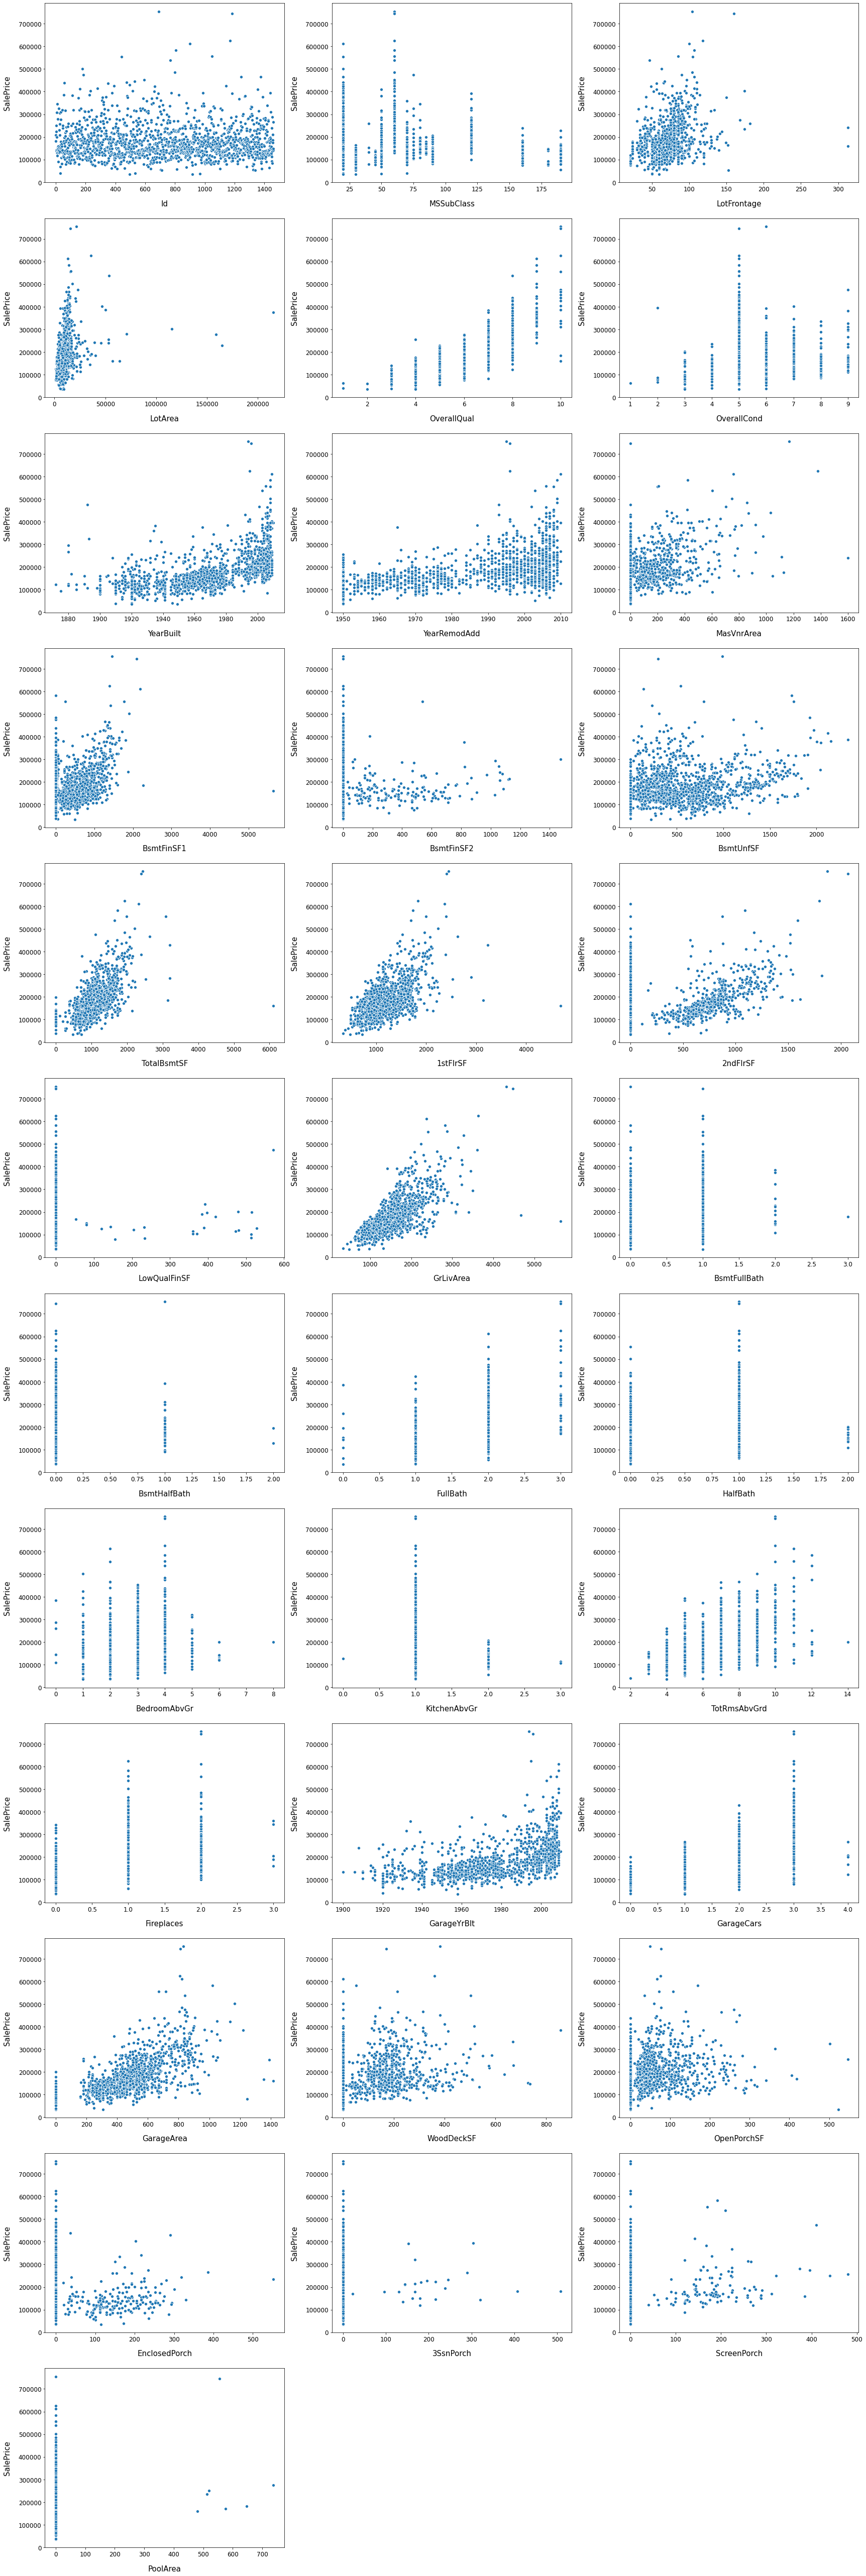

In [52]:
# Finding numeric features
numeric_dtypes = ['int64', 'float64']
numeric = []
for i in df.columns:
    if df[i].dtype in numeric_dtypes:
        if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numeric.append(i)     
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("Paired")
for i, feature in enumerate(list(df[numeric]), 1):
    if(feature=='MiscVal'):
        break
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', palette="deep", data=df)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=14.5)
    plt.ylabel('SalePrice', size=15, labelpad=14.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
        
plt.show()

# Features that have non-linear pattern (with SalePrice as y)
    -PoolArea
    -ScreenPorch
    -3SsnPorch
    -GarageArea (?)
    -KitchenAbvGr
    -BsmtHalfBath
    -BsmtFullBath
    -LowQualFinSF

In [53]:
all_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [54]:
all_df.loc[all_df.Alley.notnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
36,1497,160,FV,39.0,3515,Pave,Pave,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,1,2010,WD,Normal
37,1498,160,FV,30.0,3215,Pave,Pave,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,ConLD,Normal
38,1499,160,FV,24.0,2544,Pave,Pave,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
39,1500,160,FV,24.0,2544,Pave,Pave,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
42,1503,20,FV,57.0,12853,Pave,Pave,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,New,Partial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,1405,50,RL,60.0,10410,Pave,Grvl,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,1,2006,WD,Family
1414,1415,50,RL,64.0,13053,Pave,Pave,Reg,Bnk,AllPub,...,220,0,NaN,NaN,NaN,0,6,2008,WD,Normal
1427,1428,50,RL,60.0,10930,Pave,Grvl,Reg,Bnk,AllPub,...,0,0,NaN,NaN,NaN,0,4,2008,WD,Normal
1432,1433,30,RL,60.0,10800,Pave,Grvl,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal


# Some feature engineering

In [55]:
#filling NaNs - MSZoning and LotFrontage, based on other features
all_df['MSZoning'] = all_df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
all_df['LotFrontage'] = all_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [56]:
#creating more cols!
all_df['general_qual'] = all_df['OverallQual'] + all_df['OverallCond']
all_df['build_remodel'] = all_df['YearRemodAdd'] - all_df['YearBuilt']

In [57]:
#sum of bathrooms
all_df['baths'] = (all_df.BsmtFullBath) + (all_df.BsmtHalfBath * 0.5)

In [17]:
#transforming year and month into categorical!
all_df['MoSold'] = all_df['MoSold'].astype(str) 
all_df['YrSold'] = all_df['YrSold'].astype(str)

In [18]:
# Creating a feature with 3SsnPorch based on 0 or non 0
all_df['3SsnPorch_exist'] =all_df['3SsnPorch'].apply(lambda x: 1 if x!=0 else 0)

In [19]:
#Creating a feature for 2nd floor existence and GrLivArea
all_df['2ndFlrExist'] = all_df['2ndFlrSF'].apply(lambda x: 1 if x!=0 else 0)
all_df['GrLivAreaExist'] = all_df['GrLivArea'].apply(lambda x: 1 if x!=0 else 0)

In [20]:
#filling the categorical values with None (str)
for i in all_df.select_dtypes(include='object').columns:
    all_df[i].fillna('None',inplace=True)

In [21]:
#filling the non categorical values with 0
for i in all_df.select_dtypes(exclude='object').columns:
    all_df[i].fillna(0,inplace=True)

# Looking at the dataset

In [22]:
all_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MoSold,YrSold,SaleType,SaleCondition,general_qual,build_remodel,baths,3SsnPorch_exist,2ndFlrExist,GrLivAreaExist
0,1461,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,...,6,2010,WD,Normal,11,0,0.0,0,0,1
1,1462,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,...,6,2010,WD,Normal,12,0,0.0,0,0,1
2,1463,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,...,3,2010,WD,Normal,10,1,0.0,0,1,1
3,1464,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,...,6,2010,WD,Normal,12,0,0.0,0,1,1
4,1465,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,...,1,2010,WD,Normal,13,0,0.0,0,0,1


In [23]:
all_df.iloc[:,1:20]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt
0,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961
1,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958
2,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997
3,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998
4,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999
1456,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978
1457,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941
1458,20,RL,68.0,9717,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950


In [24]:
all_df.iloc[:,20:40]

,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating
0,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA
1,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA
2,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA
3,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA
4,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,953.0,953.0,GasA
1456,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790.0,Rec,163.0,589.0,1542.0,GasA
1457,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275.0,Unf,0.0,877.0,1152.0,GasA
1458,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49.0,Rec,1029.0,0.0,1078.0,GasA


In [25]:
all_df.iloc[:,40:60]

,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt
0,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,None,Attchd,1961.0
1,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,None,Attchd,1958.0
2,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0
3,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0
4,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,None,Attchd,1992.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,Ex,Y,SBrkr,953,694,0,1647,0.0,0.0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0
1456,TA,Y,SBrkr,2073,0,0,2073,1.0,0.0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0
1457,Ex,Y,SBrkr,1188,1152,0,2340,0.0,0.0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0
1458,Gd,Y,FuseA,1078,0,0,1078,1.0,0.0,1,0,2,1,Gd,5,Typ,0,None,Attchd,1950.0


In [26]:
all_df.iloc[:,60:80]

,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,None,MnPrv,None,0,6,2010,WD,Normal
1,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,None,None,Gar2,12500,6,2010,WD,Normal
2,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,None,MnPrv,None,0,3,2010,WD,Normal
3,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,None,None,None,0,6,2010,WD,Normal
4,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,None,None,None,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RFn,2.0,460.0,TA,TA,Y,0,40,0,0,0,0,None,None,None,0,8,2007,WD,Normal
1456,Unf,2.0,500.0,TA,TA,Y,349,0,0,0,0,0,None,MnPrv,None,0,2,2010,WD,Normal
1457,RFn,1.0,252.0,TA,TA,Y,0,60,0,0,0,0,None,GdPrv,Shed,2500,5,2010,WD,Normal
1458,Unf,1.0,240.0,TA,TA,Y,366,0,112,0,0,0,None,None,None,0,4,2010,WD,Normal


In [27]:
all_df.iloc[:,80:]

,general_qual,build_remodel,baths,3SsnPorch_exist,2ndFlrExist,GrLivAreaExist
0,11,0,0.0,0,0,1
1,12,0,0.0,0,0,1
2,10,1,0.0,0,1,1
3,12,0,0.0,0,1,1
4,13,0,0.0,0,0,1
...,...,...,...,...,...,...
1455,11,1,0.0,0,1,1
1456,12,10,1.0,0,0,1
1457,16,65,0.0,0,1,1
1458,11,46,1.0,0,0,1


In [28]:
#applying get_dummies!
all_df = pd.get_dummies(all_df)

In [29]:
all_df.shape

(2919, 331)

In [30]:
#Removing duplicated columns if exists
all_df = all_df.loc[:,~all_df.columns.duplicated()]
all_df.shape

(2919, 331)

In [31]:
#applying RobustScaler into our X
all_df = pd.DataFrame(RobustScaler().fit_transform(all_df),columns=all_df.columns)

In [32]:
#Spliting - Train and Test again!
train_labels = all_df.iloc[:len(df), :].copy()
X_test = all_df.iloc[len(train_labels):, :].copy()
all_df.shape, train_labels.shape, X_test.shape

((2919, 331), (1460, 331), (1459, 331))

In [33]:
X_train_house, X_test_house, y_train_house, y_test_house =\
    train_test_split(train_labels.copy(),np.log1p(df['SalePrice']).copy(),random_state=42,test_size=0.2)
                     
xgb = XGBRegressor(random_state=6534).fit(X_train_house,y_train_house)
rf = RandomForestRegressor(random_state=6534).fit(X_train_house,y_train_house)
catboost = CatBoostRegressor(random_state=6534,verbose=0).fit(X_train_house,y_train_house)

y_pred_house_ = (xgb.predict(X_test_house) * 0.34 ) + (rf.predict(X_test_house) * 0.33 ) +\
                     (catboost.predict(X_test_house) * 0.33)

y_pred_house = np.floor(np.expm1(y_pred_house_))
y_test_house = np.floor(np.expm1(y_test_house))

#### TRYING TO MINIMIZE RMSE ###
#q1 = np.quantile(y_pred_house,0.0045)
#q2 = np.quantile(y_pred_house,0.99)
#y_pred_house = pd.Series(y_pred_house).apply(lambda x: x if x > q1 else x*0.77)
#y_pred_house = y_pred_house.apply(lambda x: x if x < q2 else x*1.1)

#y_pred_house  *= 1.001619
#----------------------------#

MAE_test = metrics.mean_absolute_error(y_test_house, y_pred_house)
R2_test = metrics.r2_score(y_test_house, y_pred_house)
RMSE_test = sqrt(metrics.mean_squared_error(y_test_house, y_pred_house))

print('--- Test evaluation ---')
print('MAE:', round(MAE_test,2))
print('R2: ', round(R2_test,2))
print('RMSE: ',round(RMSE_test,2))

--- Test evaluation ---
MAE: 62242.33
R2:  -0.07
RMSE:  90795.71


In [34]:
#Changing the target scale 
y_train = np.log1p(df['SalePrice'].copy())

In [35]:
#creating & fitting our models!
xgb = XGBRegressor(random_state=6534).fit(train_labels,y_train)
rf = RandomForestRegressor(random_state=6534).fit(train_labels,y_train)
catboost = CatBoostRegressor(random_state=6534,verbose=0).fit(train_labels,y_train)

In [36]:
#predicting our values!
y_pred = (xgb.predict(X_test) * 0.34 ) + (rf.predict(X_test) * 0.33 ) + (catboost.predict(X_test) * 0.33)

In [37]:
submission = pd.read_csv("../data/houseprice/sample_submission.csv")
submission.shape

(1459, 2)

In [38]:
#Rescaling our target!
submission.iloc[:,1] = np.floor(np.expm1(y_pred))

In [39]:
submission.to_csv("submission_regression0.csv", index=False)

In [40]:
#Fixing outliers! If the value is too high or too low
q1 = submission['SalePrice'].quantile(0.0045)
q2 = submission['SalePrice'].quantile(0.99)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submission_regression1.csv", index=False)

In [41]:
#fixing some probable scale error
submission['SalePrice'] *= 1.001619
submission.to_csv("submission_regression2.csv", index=False)